In [1]:
import pandas as pd
import numpy as np
import torch
import cv2
import math
import os
import matplotlib.pyplot as plt
import zipfile

In [2]:
import tensorflow
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

tensorflow.__version__

2024-09-27 14:57:05.215737: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-27 14:57:05.224981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 14:57:05.236192: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 14:57:05.239519: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 14:57:05.247893: I tensorflow/core/platform/cpu_feature_guar

'2.17.0'

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

'''
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
    try: 
        tensorflow.config.set_logical_device_configuration(gpus[0], [tensorflow.config.LogicalDeviceConfiguration(memory_limit=3900)])
        logical_gpus = tensorflow.config.list_logical_devices('GPU')
        print(len(gpus), "Phyisical GPUs, ", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
'''

gpus = tensorflow.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tensorflow.config.experimental.set_memory_growth(gpu, True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 360257508406719424
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2278096896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8477313936919110500
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


I0000 00:00:1727459826.291097    9349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727459826.293080    9349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727459826.294184    9349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727459826.382525    9349 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
#df = pd.read_csv('./fer2013/fer2013.csv')

In [5]:
batch_size = 1
image_size = 48

In [6]:
training_data = image_dataset_from_directory('./fer2013/train/', labels='inferred', label_mode='categorical', batch_size=batch_size, image_size=(image_size, image_size), shuffle=True, color_mode='grayscale')
training_data = training_data.repeat()

Found 28711 files belonging to 7 classes.


I0000 00:00:1727459826.927596    9349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727459826.928825    9349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727459826.929819    9349 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727459826.931217    9349 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [7]:
validation_data = image_dataset_from_directory('./fer2013/validation/', labels='inferred', label_mode='categorical', batch_size=batch_size, image_size=(image_size, image_size), shuffle=True, color_mode='grayscale')
validation_data = validation_data.repeat()

Found 3589 files belonging to 7 classes.


In [8]:
emotions = ["Angry", "Disgusted", "Afraid", "Happy", "Neutral", "Sad", "Surprised"]

In [9]:
training_data_normalized = training_data.map(lambda x, y: (x/255, y))
validation_data_normalized = validation_data.map(lambda x, y: (x/255, y))

(1, 48, 48, 1)


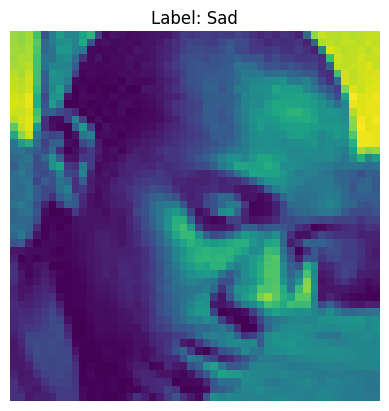

2024-09-27 14:57:07.829645: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
sample = training_data_normalized.take(1)
for image_batch, labels_batch in sample:
    print(image_batch.shape)
    first_image = image_batch[0]
    first_label = labels_batch[0]
    plt.imshow((first_image.numpy() * 255).astype('uint8'))
    plt.title(f"Label: {emotions[np.argmax(first_label)]}")
    plt.axis("off")
    plt.show()

In [11]:
num_features = 256
num_labels = 7 #len(emotions)
epochs = 100
width, height = image_size, image_size

i = Input(shape=(width, height, 1))
x = Conv2D(num_features, kernel_size = (3,3), activation="relu", padding = 'same', kernel_regularizer = l2(0.01))(i)
x = Conv2D(num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(2*num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(2*num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(2*2*num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(2*2*num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(2*2*2*num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(2*2*2*num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)

x = Dense(2*2*2*num_features, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(2*2*num_features, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(2*num_features, activation='relu')(x)
x = Dropout(0.5)(x)

o = Dense(num_labels, activation='softmax')(x)

model = Model(inputs = i, outputs = o, name='Emotion_recon_3000')

model.summary()

#model.compile(optimizer = Adam(weight_decay=None, learning_rate=0.9), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "Emotion_recon_3000"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 1024)   │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 1024)   │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 1024)   │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 2048)     │    18,876,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 6, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 2048)     │    37,750,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 2048)     │         8,19

 Total params: 115,324,679 (439.93 MB)

 Trainable params: 115,309,831 (439.87 MB)

 Non-trainable params: 14,848 (58.00 KB)

num_features = 64
num_labels = 7
epochs = 100
width, height = image_size, image_size

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu',
                 input_shape=(width, height, 1), data_format = 'channels_last',
                 kernel_regularizer = l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation = 'softmax'))

model.summary()

In [12]:
model_file = 'expression_recognition_01.keras'
model_file_json = 'expression_recognition_01.json'

lr_reducer = ReduceLROnPlateau(factor = 0.9, patience = 6, mode = 'auto', verbose = 1, min_lr=0.0000000001)
early_stopper = EarlyStopping(patience=15)
checkpointer = ModelCheckpoint(model_file, verbose = 1, save_best_only = True)

model_json = model.to_json()
with open(model_file_json, 'w') as json_file:
    json_file.write(model_json)

In [13]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics = ['accuracy'])

arquivo_modelo = 'modelo_01_expressoes.keras'
arquivo_modelo_json = 'modelo_01_expressoes.json'

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor = 0.8, patience=3, verbose = 1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience = 8, verbose = 1, mode = 'auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose = 1, save_best_only=True)

In [14]:
history = model.fit(training_data_normalized,
                    epochs = epochs,
                    steps_per_epoch = 10,
                    validation_data = validation_data_normalized,
                    callbacks = [lr_reducer, checkpointer],
                    validation_steps = 10)

Epoch 1/100


I0000 00:00:1727459831.699342    9420 service.cc:146] XLA service 0x7f76c00027d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727459831.699360    9420 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-09-27 14:57:11.790607: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-27 14:57:12.184630: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-27 14:57:15.101017: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-27 14:57:15.470744: W external/local_tsl/tsl/framework/bfc_allocator

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib64/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib64/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/usr/lib64/python3.12/asyncio/events.py", line 88, in _run

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_9349/1384525204.py", line 1, in <module>

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 150994944 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.29GiB
              constant allocation:        52B
        maybe_live_out allocation:    1.29GiB
     preallocated temp allocation:  576.09MiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    1.85GiB
              total fragmentation:    16.1KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 144.00MiB
		Operator: op_type="Conv2DBackpropFilter" op_name="gradient_tape/Emotion_recon_3000_1/conv2d_7_1/convolution/Conv2DBackpropFilter" source_file="/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: custom-call
		Shape: f32[2048,2048,3,3]
		==========================

	Buffer 2:
		Size: 144.00MiB
		XLA Label: fusion
		Shape: f32[3,3,2048,2048]
		==========================

	Buffer 3:
		Size: 144.00MiB
		XLA Label: fusion
		Shape: f32[3,3,2048,2048]
		==========================

	Buffer 4:
		Size: 144.00MiB
		Operator: op_name="XLA_Args"
		XLA Label: fusion
		Shape: f32[2048,2048,3,3]
		==========================

	Buffer 5:
		Size: 144.00MiB
		Operator: op_type="AssignSubVariableOp" op_name="adam/AssignSubVariableOp_30" source_file="/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: fusion
		Shape: f32[18432,2048]
		==========================

	Buffer 6:
		Size: 144.00MiB
		Operator: op_type="AssignSubVariableOp" op_name="adam/AssignSubVariableOp_30" source_file="/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: fusion
		Shape: f32[18432,2048]
		==========================

	Buffer 7:
		Size: 144.00MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[3,3,2048,2048]
		==========================

	Buffer 8:
		Size: 144.00MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[3,3,2048,2048]
		==========================

	Buffer 9:
		Size: 144.00MiB
		Operator: op_type="AssignSubVariableOp" op_name="adam/AssignSubVariableOp_30" source_file="/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1177
		XLA Label: fusion
		Shape: f32[18432,2048]
		==========================

	Buffer 10:
		Size: 144.00MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[3,3,2048,2048]
		==========================

	Buffer 11:
		Size: 72.00MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[3,3,1024,2048]
		==========================

	Buffer 12:
		Size: 72.00MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[3,3,1024,2048]
		==========================

	Buffer 13:
		Size: 72.00MiB
		Operator: op_name="XLA_Retvals"
		XLA Label: fusion
		Shape: f32[3,3,1024,2048]
		==========================

	Buffer 14:
		Size: 36.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,1024,1024]
		==========================

	Buffer 15:
		Size: 36.00MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,1024,1024]
		==========================


	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_8310]

In [ ]:
history